# **Базовая версия контроля качества и анализа сырых данных**

> Для использования notebook нужно скачать и организовать сырые данные с помощью **download_raw_data.py** и **organize_raw_data.py** в директории project/src/data/

## Подготовка датасета

- Импортируем нужные нам библиотеки

In [75]:
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

- Создаем две константы, путь к файлам проекта и путь к файлам сырых данных
- Создаем переменную которая хранит путь к нашему файлу csv
- После проверки есть ли такой файл в директории импортируем данные в формат pd.DataFrame
- Для проверки выводим первые 5 строк датасета

In [76]:


PROJECT_PATH = Path().cwd().parent
DATA_RAW_PATH = PROJECT_PATH / "data" / "raw"

csv_path = DATA_RAW_PATH / "vehicle_detection" / "labels" / "_annotations.csv"

if csv_path.exists():
    ds = pd.read_csv(csv_path)
    print(ds.head())
else:
   ds = pd.DataFrame() 

                                            filename  width  height  \
0  1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
1  1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
2  1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
3  1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
4  1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   

        class  xmin  ymin  xmax  ymax  
0         car   291   247   370   331  
1  pedestrian   270   235   293   321  
2         car     0   266    13   327  
3         car    25   258   106   304  
4         car   111   259   135   289  


## Проверка качества данных

- Выводим процент количества пустых значений в каждом столбце таблицы
- Выводим строки-дубликаты

In [77]:
print(ds.isna().mean()*100)
print("-"*50)

duplicates = ds[ds.duplicated(keep=False)]
print(duplicates)
print("-"*50)

filename    0.0
width       0.0
height      0.0
class       0.0
xmin        0.0
ymin        0.0
xmax        0.0
ymax        0.0
dtype: float64
--------------------------------------------------
                                                 filename  width  height  \
1537    1478898145212453716_jpg.rf.6a92d7d7dd523160c99...    512     512   
1538    1478898145212453716_jpg.rf.6a92d7d7dd523160c99...    512     512   
5393    1478898404006867689_jpg.rf.7234d4f28a6f0854189...    512     512   
5394    1478898404006867689_jpg.rf.7234d4f28a6f0854189...    512     512   
23222   1478897760163798179_jpg.rf.98623be50b02ff17d58...    512     512   
23223   1478897760163798179_jpg.rf.98623be50b02ff17d58...    512     512   
30558   1478021875081281646_jpg.rf.e9552980cf8c6fef4aa...    512     512   
30559   1478021875081281646_jpg.rf.e9552980cf8c6fef4aa...    512     512   
47747   1478732830206963711_jpg.rf.jZ8zJTdU09n0OlbXEE5...    512     512   
47748   1478732830206963711_jpg.rf.jZ8zJTdU09n

Теперь проводим проверку датасета на логику, а именно чтобы:
- Высота и ширина изображений были только 512х512
- Минимальные значения х и у для Bounding Boxes были меньше максимальных значений 
- Значения х и y Bounding Boxes были в рамках [0,512]
- Классы изображений существовали в словаре всех возможных классов

In [78]:
print(ds[(ds["width"]!=512) & (ds["height"]!=512)]) 
print("-"*50)

print(ds[(ds["xmin"]>ds["xmax"]) | (ds["ymin"]>ds["ymax"])]) 
print("-"*50)

print(ds[( ds["xmin"]<0 ) | ( ds["xmin"]>512 ) | 
         ( ds["ymin"]<0 ) | ( ds["ymin"]>512 ) | 
         ( ds["xmax"]<0 ) | ( ds["xmax"]>512 ) | 
         ( ds["ymax"]<0 ) | ( ds["ymax"]>512 ) ]) 
print("-"*50)

unique_classes = ['car', 'pedestrian', 'biker', 'truck', 'trafficLight-Red', 'trafficLight',
                  'trafficLight-Green', 'trafficLight-RedLeft', 'trafficLight-GreenLeft',
                  'trafficLight-Yellow', 'trafficLight-YellowLeft']
print(ds[~ds["class"].isin(unique_classes)]) 
print("-"*50)

Empty DataFrame
Columns: [filename, width, height, class, xmin, ymin, xmax, ymax]
Index: []
--------------------------------------------------
Empty DataFrame
Columns: [filename, width, height, class, xmin, ymin, xmax, ymax]
Index: []
--------------------------------------------------
Empty DataFrame
Columns: [filename, width, height, class, xmin, ymin, xmax, ymax]
Index: []
--------------------------------------------------
Empty DataFrame
Columns: [filename, width, height, class, xmin, ymin, xmax, ymax]
Index: []
--------------------------------------------------


## Визуальный анализ

- Сделаем гистограмму распределения количества классов объектов на фото, чтобы понимать на скольких данных модель будет обучаться для каждого класса

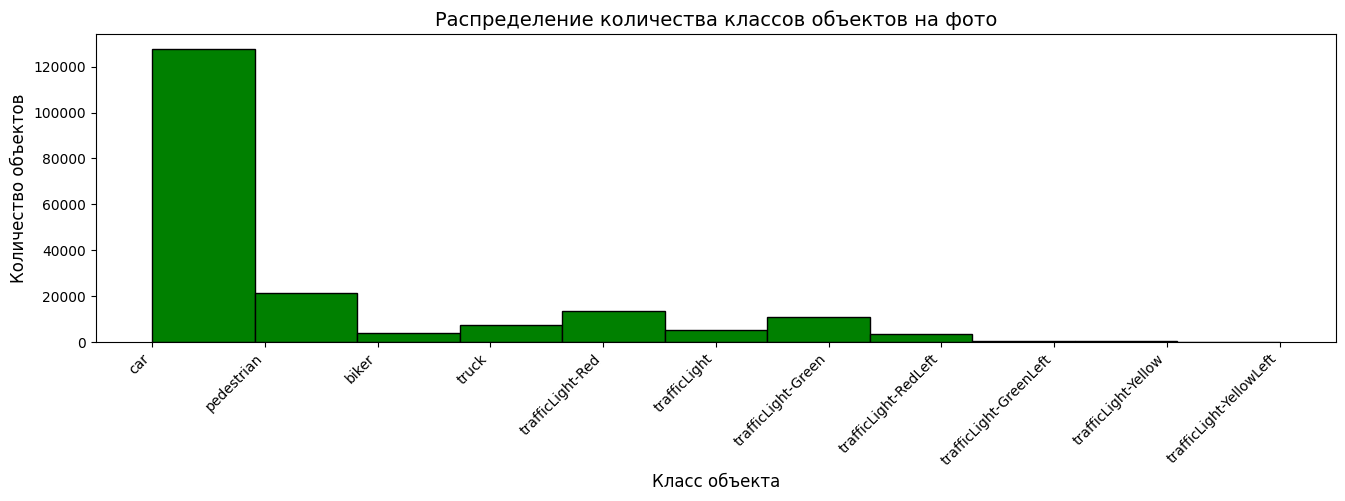

In [79]:
fig,ax = plt.subplots(figsize=(16,4))
n_bins = len(unique_classes)
ax.hist(ds["class"],bins=n_bins,color="g",edgecolor="black")
ax.set_xlabel("Класс объекта",fontsize=12)
ax.set_ylabel("Количество объектов",fontsize=12)
ax.set_title("Распределение количества классов объектов на фото",fontsize=14)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
#plt.savefig('figures/classes_histogram.png')
plt.show()

## Итоговые результаты

По итогам базового анализа наших данных могу сделать несколько выводов:
- Нет ни единого пропуска
- Отличный результат показала логика данных - нет ни единой ошибки, все в рамках реального и допустимого
- Плохой результат выдал пункт дубликатов, их нашлось довольно много 
- Судя по выведенному графику можно смело сказать, что модель, скорее всего, будет недостаточно хорошо определять типы светофоров, и еще некоторые типы транспорта, в данных предпочтение отдано машинам